# Efficiency of ALOHA for Random Access

In [1]:
import numpy as np
from scipy.special import erfc, erfcinv
import matplotlib.pyplot as plt


Q = lambda x: 0.5 * erfc(x / np.sqrt(2))
Q_inv = lambda x: np.sqrt(2) * erfcinv(2 * x)

rng = np.random.default_rng()

N = 30000 # frame length
k = 100 # number of info bits
p_error = 0.1 # allowed error rate


rates = np.linspace(k/N, 5, 30)

We will simulate our ALOHA scheme over an AWGN channel and assume channel coding which achieves the finite blocklength capacity approximation in:

>Y. Polyanskiy, H. V. Poor and S. Verdu, "Channel Coding Rate in the Finite Blocklength Regime," in IEEE Transactions on Information Theory, vol. 56, no. 5, pp. 2307-2359, May 2010, doi: 10.1109/TIT.2010.2043769.
>
>See also: 'Channel Coding -- Graph Based Codes' slides for chapter 2

Text(0.5, 0, 'Rate $r$')

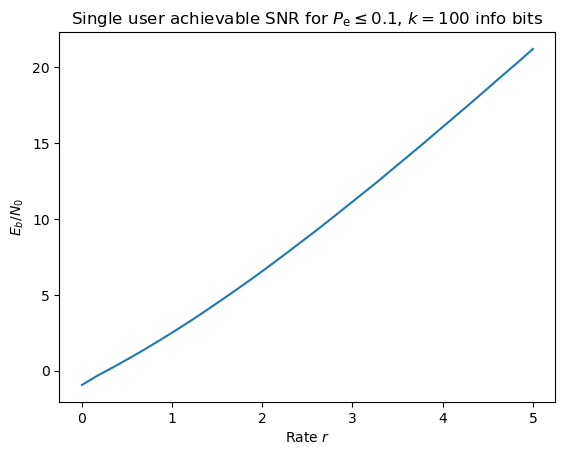

In [2]:
def error_probability_for_code(r: float, n: int, channel_snr: float) -> float:
    """ Return the best error probability for a code with a given rate and block length

    - `r`: Code rate
    - `n`: Block length
    - `channel_snr`: Signal to noise ratio (E_s/N_0) of the (real valued) AWGN channel in dB

    Returns:
    p_e: Minimum error probability for a code with rate r and block length n according to the approximation in Y. Polyanskiy, H. V. Poor and S. Verdu, "Channel Coding Rate in the Finite Blocklength Regime," in IEEE Transactions on Information Theory, vol. 56, no. 5, pp. 2307-2359, May 2010, doi: 10.1109/TIT.2010.2043769.
    """

    snr_lin = 10**(channel_snr/10)

    V = 0.5 * snr_lin * (snr_lin + 2) / (snr_lin + 1)**2 * np.log2(np.e)**2
    C = 0.5 * np.log2(1 + snr_lin)
    
    return Q(np.sqrt(n/V) * (C + np.log2(n)/2/n - r))

def channel_ebn0_for_error_probability(r: float, k: int, p_error: float, rel_diff: float = 0.01) -> float:
    """ Return the minimum channel_ebn0 for an error probability below `p_error`

    - `r`: Code rate
    - `k`: Num info bits
    - `p_error`: Error probability

    Returns:
    channel_ebn0: Signal to noise ratio (E_b/N_0) of the (real valued) AWGN channel in dB
    """
    n = min(N, round(k / r))

    min_ebn0 = -5
    max_ebn0 = 50
    found_pe = None

    counter = 0
    # binary search
    while counter == 0 or not (1 - rel_diff) * p_error <= found_pe <= (1 + rel_diff) * p_error:
        test_ebn0 = (max_ebn0 + min_ebn0) / 2
        test_esn0 = test_ebn0 + 10 * np.log10(r) # convert E_s/N_0 to E_b/N_0
        found_pe = error_probability_for_code(r, n, test_esn0)

        if found_pe > p_error:
            min_ebn0 = test_ebn0
        else:
            max_ebn0 = test_ebn0
        
        if counter > 1000:
            print(f'WARNING: Out of iterations! {min_ebn0=}, {max_ebn0=}, {test_ebn0=}, {found_pe=}')
            break
        else:
            counter += 1
        
    return test_ebn0 - 10 * np.log10(2) # use complex channel snr


channel_ebn0 = np.array([channel_ebn0_for_error_probability(r, k, p_error) for r in rates])
plt.plot(rates, channel_ebn0)
plt.title(f'Single user achievable SNR for $P_\mathrm{{e}} \leq {p_error}$, $k={k}$ info bits')
plt.ylabel(r'$E_b/N_0$')
plt.xlabel('Rate $r$')

## ALOHA

All $K_\mathrm{a}$ active users send their data at random times.

Lower rates with a fixed number of $k$ info bits per user lead to longer block lengths and more collisions.
We first simulate the expected number of collisions per block length.

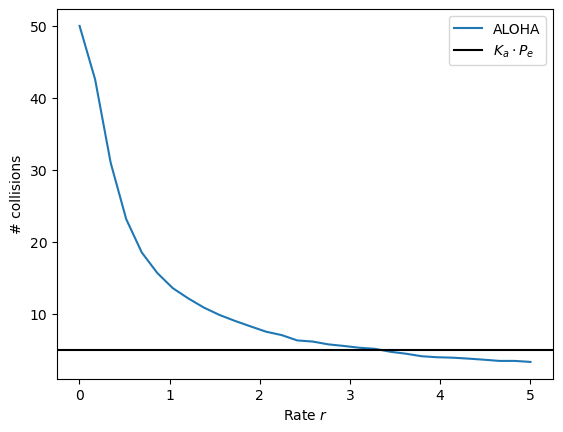

In [3]:
def simulate_num_collisions(K_a: int, rates: np.ndarray) -> np.ndarray:
    num_collisions = [[] for _ in rates]

    for _ in range(100): # average of 100 random samples
        tx_times = rng.integers(0, N, K_a)

        for r_idx, r in enumerate(rates):
            n = min(round(k / r), N)

            collisions = [
                any([
                    other_tx_time <= tx_time <= other_tx_time + n or other_tx_time <= tx_time + n <= other_tx_time + n
                    for j, other_tx_time in enumerate(tx_times) if i != j
                ])
                for i, tx_time in enumerate(tx_times)
            ]
            num_collisions[r_idx].append(np.count_nonzero(collisions))

    avg_num_collisions = np.mean(num_collisions, axis=1)

    return avg_num_collisions

K_a = 50

avg_num_collisions = simulate_num_collisions(K_a, rates)

plt.plot(rates, avg_num_collisions, label='ALOHA')
plt.gca().axhline(K_a * p_error, color='k', label='$K_a \cdot P_e$')
plt.xlabel('Rate $r$')
plt.ylabel('# collisions')
plt.legend()

As all collisions also lead to packet errors, higher collision rates require lower decoding error rates to fulfill the error rate constraint $P_\mathrm{e} \leq 0.1$. We have
$$
\begin{align*}
P_\mathrm{e}
    &= P(\text{collision} \lor \text{decoding error}) \\
    &= 1 - P\big(\overline{\text{collision}} \land \overline{\text{decoding error}}\big) \\
    &= 1 - P\big(\overline{\text{collision}}\big) P\big(\overline{\text{decoding error}}\big) \\
    &= 1 - (1 - P(\text{collision})) (1 - P(\text{decoding error})) \\
\implies \quad P(\text{decoding error}) &= 1 - \frac{1 - P_\mathrm{e}}{1 - P(\text{collision})}.
\end{align*}
$$
Next, we find the required $\frac{E_\mathrm{b}}{N_0}$ to achieve this decoding error probability.

To successfully transmitt a bit that is collided with $P(\text{collision})$ we need to transmit it $\frac1{1 - P(\text{collision})}$ times on average (geometric distribution).
If each transmission uses the energy $E_\mathrm{b}$, the effective energy to transmit one bit is $E_\mathrm{b,eff} = \frac{E_\mathrm{b}}{1 - P(\text{collision})}$.
From this we calculate the effective SNR
$$
\frac{E_\mathrm{b,eff}}{N_0} = \frac1{1 - P(\text{collision})} \cdot \frac{E_\mathrm{b}}{N_0}.
$$

np.float64(15.096902824303518)

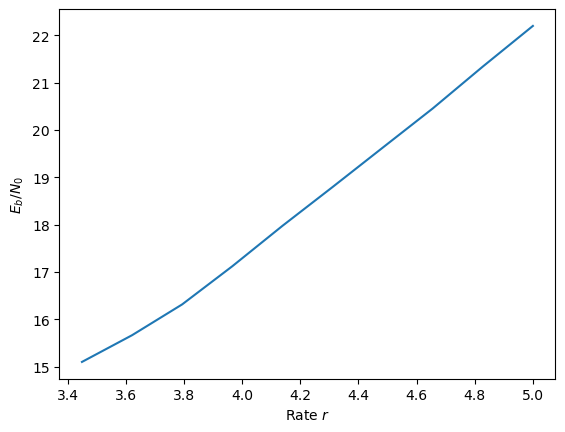

In [4]:
def find_best_ebn0(K_a: int, num_collisions: np.ndarray, channel_ebn0: np.ndarray, plot: bool = False) -> float:
    p_collision = num_collisions / K_a
    mask = p_collision < p_error # if p_collision > p_error even perfect transmission can not achieve p_error in total

    channel_ebn0 = np.array([
        channel_ebn0_for_error_probability(r, k, 1 - (1 - p_error) / (1 - p_coll))
        for r, p_coll in zip(rates[mask], p_collision[mask])
    ])
    energy_per_received = channel_ebn0 - 10 * np.log10(1 - p_collision[mask]) # compute effective SNR

    min_ebn0 = np.min(energy_per_received) if len(energy_per_received) > 0 else None

    if plot:
        plt.plot(rates[mask], energy_per_received)
        plt.xlabel('Rate $r$')
        plt.ylabel('$E_b/N_0$')

    return min_ebn0


find_best_ebn0(K_a, avg_num_collisions, channel_ebn0, plot=True)

Define a function that takes the number of active users $K_\mathrm{a}$ and returns the minimum $E_\mathrm{b}/N_0$ for which an error rate above $P_\mathrm{e}$ is possible.

In [5]:
def eb_n0_for_K_a(K_a: int): # execute function defined above for any K_a

    avg_num_collisions = simulate_num_collisions(K_a, rates)

    min_ebn0 = find_best_ebn0(K_a, avg_num_collisions, channel_ebn0)

    return min_ebn0

Finally, plot the required $E_\mathrm{b}/N_0$ over $K_\mathrm{a}$.

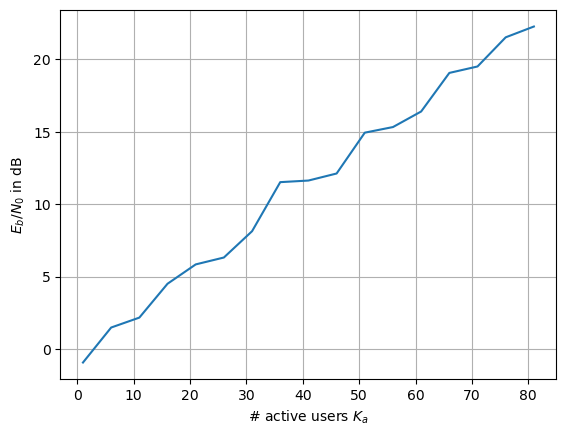

In [6]:
active_user_range = np.arange(1, 100, 5)

eb_n0 = np.array([eb_n0_for_K_a(K_a) for K_a in active_user_range])

plt.plot(active_user_range, eb_n0)
plt.xlabel('# active users $K_a$')
plt.ylabel('$E_b/N_0$ in dB')
plt.grid()

## Slotted Aloha

The time is split into slots and the user transmissions are aligned to the slot boundaries. This eliminates many cases where only the first or last few symbols of users overlapp.

We simmulate the number of collisiond depending on the rate again.

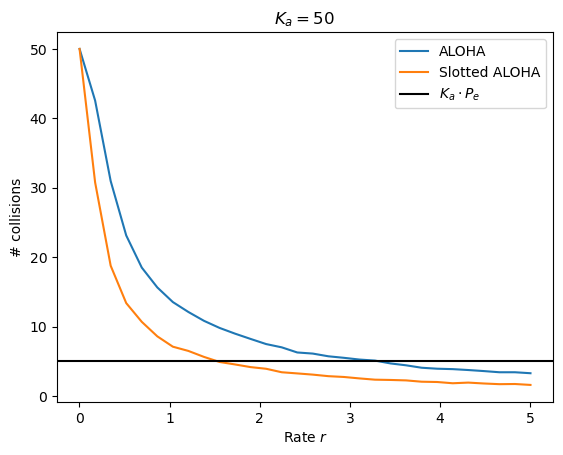

In [7]:
def count_collisions(tx_slots):
    tx_per_slot = np.unique_counts(tx_slots).counts
    collisions = tx_per_slot[tx_per_slot > 1]
    return np.sum(collisions)

def simulate_num_collisions_slotted(K_a: int, rates: np.ndarray) -> np.ndarray:
    num_collisions_per_rate = []

    for r_idx, r in enumerate(rates):
        n = min(round(k / r), N)

        num_slots = N // n

        tx_times = rng.integers(0, num_slots, (1000, K_a))
        num_collisions = np.apply_along_axis(count_collisions, axis=1, arr=tx_times)

        num_collisions_per_rate.append(np.mean(num_collisions))

    return np.array(num_collisions_per_rate)


avg_num_collisions_slotted = simulate_num_collisions_slotted(K_a, rates)

plt.plot(rates, avg_num_collisions, label='ALOHA')
plt.plot(rates, avg_num_collisions_slotted, label='Slotted ALOHA')
plt.gca().axhline(K_a * p_error, color='k', label='$K_a \cdot P_e$')
plt.xlabel('Rate $r$')
plt.ylabel('# collisions')
plt.title(f'$K_a = {K_a}$')
plt.legend()

Next, we compare slotted ALOHA to plain ALOHA for a range of $K_\mathrm{a}$.

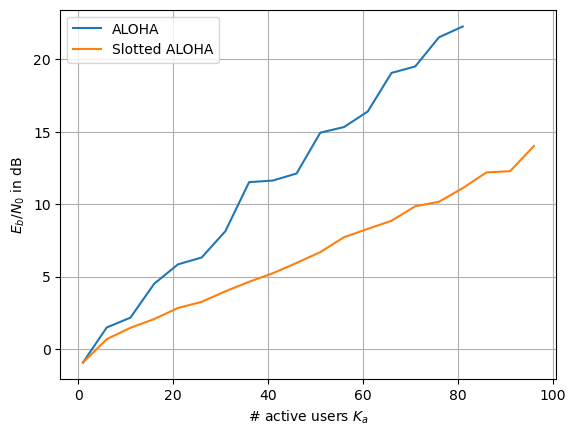

In [8]:
def eb_n0_for_K_a_slotted(K_a: int):

    avg_num_collisions = simulate_num_collisions_slotted(K_a, rates) # use slotted aloha

    min_ebn0 = find_best_ebn0(K_a, avg_num_collisions, channel_ebn0)

    return min_ebn0


eb_n0_slotted = np.array([eb_n0_for_K_a_slotted(K_a) for K_a in active_user_range])

plt.plot(active_user_range, eb_n0, label='ALOHA')
plt.plot(active_user_range, eb_n0_slotted, label='Slotted ALOHA')
plt.xlabel('# active users $K_a$')
plt.ylabel('$E_b/N_0$ in dB')
plt.legend()
plt.grid()

## Coded Slotted ALOHA

Like slotted ALOHA, but each user transmitts twice. If one of the two transmissions is received collision free, the collision of the other packet is ignored.
A successfully decoded packet can be removed from all slots it was sent in, thus removing some collisions.
This process can be repeated ($\to$ successive interference cancelation).

Once again, we simulate the number of collisions for a range of rates.

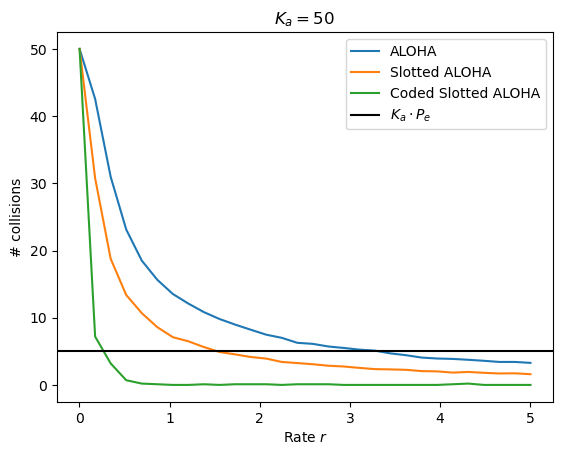

In [9]:
def count_collisions_coded(tx_slots):
    slot_counts = np.unique_counts(tx_slots)
    collided_slots = set(slot_counts.values[slot_counts.counts > 1])

    slots_per_user = tx_slots.reshape(len(tx_slots) // 2, 2)

    # one iteration of successive interference cancelation
    for user_slots in slots_per_user:
        if not np.all(np.isin(user_slots, list(collided_slots))):
            collided_slots.discard(user_slots[0])
            collided_slots.discard(user_slots[1])

    return np.count_nonzero(np.all(np.isin(slots_per_user, list(collided_slots)), axis=1))

def simulate_num_collisions_coded_slotted(K_a: int, rates: np.ndarray) -> np.ndarray:
    num_collisions_per_rate = []

    for r_idx, r in enumerate(rates):
        n = min(round(k / r), N)

        num_slots = N // n

        tx_times = rng.integers(0, num_slots, (10, 2 * K_a))
        num_collisions = np.apply_along_axis(count_collisions_coded, axis=1, arr=tx_times)

        num_collisions_per_rate.append(np.mean(num_collisions))

    return np.array(num_collisions_per_rate)


avg_num_collisions_coded_slotted = simulate_num_collisions_coded_slotted(K_a, rates)

plt.plot(rates, avg_num_collisions, label='ALOHA')
plt.plot(rates, avg_num_collisions_slotted, label='Slotted ALOHA')
plt.plot(rates, avg_num_collisions_coded_slotted, label='Coded Slotted ALOHA')
plt.gca().axhline(K_a * p_error, color='k', label='$K_a \cdot P_e$')
plt.xlabel('Rate $r$')
plt.ylabel('# collisions')
plt.title(f'$K_a = {K_a}$')
plt.legend()

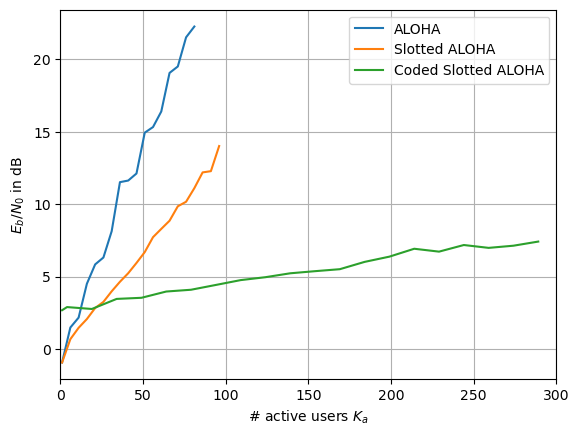

In [10]:
def eb_n0_for_K_a_coded_slotted(K_a: int):

    avg_num_collisions = simulate_num_collisions_coded_slotted(K_a, rates)

    min_ebn0 = find_best_ebn0(K_a, avg_num_collisions, channel_ebn0)

    return min_ebn0 + 3 # dB because every transmission is doubled


long_active_user_range = np.array([1, 4, 19, 34, 49, 64, 79, 94, 109, 124, 139, 154, 169, 184, 199, 214, 229, 244, 259, 274, 289])
eb_n0_coded_slotted = np.array([eb_n0_for_K_a_coded_slotted(K_a) for K_a in long_active_user_range])

plt.plot(active_user_range, eb_n0, label='ALOHA')
plt.plot(active_user_range, eb_n0_slotted, label='Slotted ALOHA')
plt.plot(long_active_user_range, eb_n0_coded_slotted, label='Coded Slotted ALOHA')
plt.xlabel('# active users $K_a$')
plt.ylabel('$E_b/N_0$ in dB')
plt.xlim(0, 300)
plt.legend()
plt.grid()

## Shannon Limit

We have seen optimistic estimates of what some schemes can achieve. But how good can we get?

Recall the sum rate bound for the Gaussian MAC
$$
r_\mathrm{sum} = r_1 + r_2 + \cdots \leq \frac12 \log_2\!\!\left(1 + \frac{P_1 + P_2 + \cdots}{\sigma^2}\right),
$$
with the per user rates $r_i$ and powers $P_i$.
Assume, all $K_\mathrm{a}$ active users have the same rate $r$ and power $P = E_\mathrm{s}$.
Then we can bound the achievable rate and SNR by
$$
\begin{align*}
    && K_\mathrm{a} \cdot r &\leq \frac12 \log_2\!\!\left(1 + K_\mathrm{a} \cdot \frac{E_\mathrm{s}}{\sigma^2}\right) \\
    &&    &= \frac12 \log_2\!\!\left(1 + K_\mathrm{a} \cdot \frac{r E_\mathrm{b}}{\sigma^2}\right) \\
    &\implies& 2^{2rK_\mathrm{a}} &\leq 1 + K_\mathrm{a} \cdot \frac{r E_\mathrm{b}}{\sigma^2} \\
    &&    &= 1 + K_\mathrm{a} \cdot \frac{2r E_\mathrm{b}}{N_0} \\
    &\implies& \frac{E_\mathrm{b}}{N_0} &\geq \frac{2^{2rK_\mathrm{a}} - 1}{2rK_\mathrm{a}}.
\end{align*}
$$

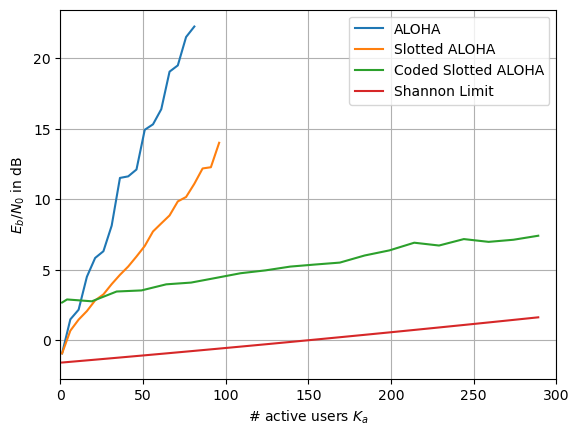

In [11]:
shannon_limit_linear = (2**(2 * k/N * long_active_user_range) - 1) / (2 * k/N * long_active_user_range)
shannon_limit = 10 * np.log10(shannon_limit_linear)

plt.plot(active_user_range, eb_n0, label='ALOHA')
plt.plot(active_user_range, eb_n0_slotted, label='Slotted ALOHA')
plt.plot(long_active_user_range, eb_n0_coded_slotted, label='Coded Slotted ALOHA')
plt.plot(long_active_user_range, shannon_limit, label='Shannon Limit')
plt.xlabel('# active users $K_a$')
plt.ylabel('$E_b/N_0$ in dB')
plt.xlim(0, 300)
plt.legend()
plt.grid()

## Random-Coding Achievability

Comparing our simulation results to the Shannon limit derived above, we notice a $\sim5\,\mathrm{dB}$ gap, especially for high numbers of active users.
However, our simple Shannon limit is not necessarily achievable without coordination between the users.
Furthermore, the Shannon limit does not consider finite block length effects.

In 2017 Yury Polyanskiy published a finite block length random-coding achievability bound for uncoordinated random access [1]. An achievability bound shows that (random) codes exist with the specified performance but, unlike a capacity, it has no converse to show that better performance is impossible.

> [1] Y. Polyanskiy, “A perspective on massive random-access,” in 2017 IEEE International Symposium on Information Theory (ISIT), Jun. 2017, pp. 2523–2527. doi: 10.1109/ISIT.2017.8006984.

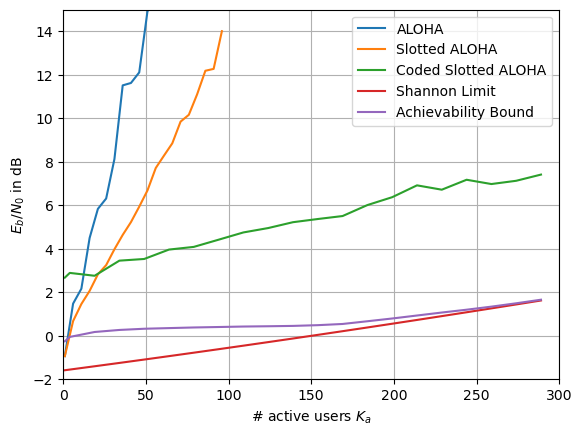

In [12]:
polyanskiy_rca = np.array([-0.25, -0.05, 0.177, 0.271, 0.326, 0.356, 0.385, 0.406, 0.428, 0.441, 0.457, 0.491, 0.546, 0.671, 0.798, 0.935, 1.072, 1.202, 1.343, 1.497, 1.662])


plt.plot(active_user_range, eb_n0, label='ALOHA')
plt.plot(active_user_range, eb_n0_slotted, label='Slotted ALOHA')
plt.plot(long_active_user_range, eb_n0_coded_slotted, label='Coded Slotted ALOHA')
plt.plot(long_active_user_range, shannon_limit, label='Shannon Limit')
plt.plot(long_active_user_range, polyanskiy_rca, label='Achievability Bound')
plt.xlabel('# active users $K_a$')
plt.ylabel('$E_b/N_0$ in dB')
plt.ylim(-2, 15)
plt.xlim(0, 300)
plt.legend()
plt.grid()